# Example of working with GHCN data from Romania

[Global historcal climate network](http://www.ncdc.noaa.gov/ghcnm/) weather station data from Romania.

N.B. Parts of this work will only function with Pandas version > 0.19.0

In [2]:
# Load some libraries
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from tqdm import *

matplotlib.style.use('ggplot')
%matplotlib inline

## Step 1: data preperation

From our Station Data files we need to create:
* one single data structure
* Date indexed data (with only one index for all the datasets)
* Station names as column identifiers

We will use the [Pandas library](http://pandas.pydata.org/pandas-docs/stable/index.html), as it is perfectly suited to our task. We have read it in above with the alias **pd**.

Before we try and read all the data, let's test a procedure with one single station file.

In [3]:
# Read a station data file with Pandas
test_data = pd.read_csv("Data/station_data/BUM00015502_VIDIN_BU_.csv")
test_data.head()

,DATE,PRCP,TAVG
0,19860301,-9999.0,-5.7
1,19860303,-9999.0,-0.1
2,19860304,0.5,0.9
3,19911129,-9999.0,5.3
4,19911201,-9999.0,5.1


Looks good, but the Dates should be an index, not a column, and they should also be a date object, not a simple integer (we get much more functionality that way).

In [4]:
# Make a list of datetime values out of the integer dates using a list comprehension technique
dates = []
for date in test_data['DATE']:
    dates.append(pd.datetime.strptime(str(date),"%Y%m%d"))
# The above could have been done more effectivley using list comprehension

# Next set the new list as an index, and remove the old column from the dataset
test_data.index = dates
test_data = test_data.drop(['DATE','PRCP'], axis=1)

test_data.head()

,TAVG
1986-03-01,-5.7
1986-03-03,-0.1
1986-03-04,0.9
1991-11-29,5.3
1991-12-01,5.1


Great! We can plot a simple preview of the data to make sure it looks good.

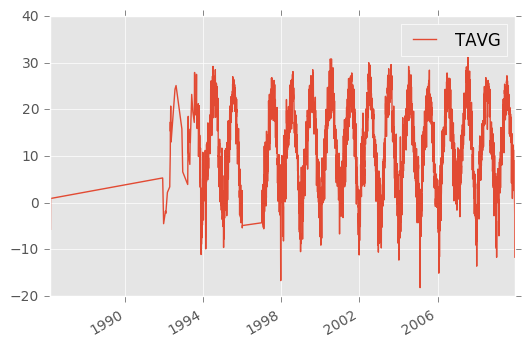

In [5]:
test_data.plot()

The preview plot is messy as our data are not contiguous, but as a quick-check, it seems like everything is more-or-less fine.

So, reading a single file is easy, and straightforward. But we want to do some exploratory analysis on multiple station measurements. For this we will need to read all the station data together into a consistent data object. 

In [6]:
# Make a small tools (functions) to help with the work

def station_name(fname):
    """Return the station ID from a path/filename.csv string"""
    tmp = fname.split('/')[-1]
    return tmp.split('_')[0]

In [ ]:
# If we were on a Mac or Linux system, we could get the file list via a bash command
flist = !ls Data/station_data/*.csv

In [8]:
# But this will break on windows. To make our code cross-platform we use a python
# library to find all the files instead. This is much better than hard-coding the files!

frames = [] # an empty list to hold each data object as it is loaded

mypath = 'Data/station_data/'          # Set path to data
for item in tqdm(os.listdir(mypath)):        # Find all files in that path and loop over them
    if '.csv' in item:                 # If the file is a csv type do something...
        fname = ''.join([mypath,item])
        station = station_name(fname)
        #print('\rReading data from station', station, end='')
        tmp = pd.read_csv(fname)
        dates = [pd.datetime.strptime(str(date),"%Y%m%d") for date in tmp['DATE']]
        tmp.index = dates
        tmp = tmp.drop(['DATE','PRCP'], axis=1) # get rid of date and precipitation columns
        tmp.columns = [station]     # Re-name TAVG to be the station name
        frames.append(tmp)
#print('\rDone reading data.')
print("{0} GHCN files read".format(len(frames)))

100%|██████████| 39/39 [00:05<00:00,  8.72it/s]

36 GHCN files read


In [9]:
df = pd.concat(frames)  # Join all the seperate data together into one object

## Step 2: Cleaning the dataset for analysis

Now we have created a dataframe **df** holding all the station data with one coherant time index.

This abstraction will do much of the work for us...

In [10]:
# First lets see how long these data run for in time
print("minimum date:", min(df.index).date())
print("maximum date:", max(df.index).date())

minimum date: 1980-01-01
maximum date: 2009-12-31


In [11]:
# Now let's look at a statistical description of these data
df.describe()

,BUM00015502,MD000033881,MD000033885,ROE00100829,ROE00100898,ROE00100899,ROE00100900,ROE00100901,ROE00100902,ROE00100903,...,ROE00108901,ROE00108903,ROM00015023,ROM00015085,ROM00015247,ROM00015280,ROM00015360,UPM00033657,UPM00033889,UPM00033898
count,5559.000000,5018.000000,3288.0,10958.0,7671.0,7671.0,10958.000000,10958.0,10958.000000,10958.0,...,10958.000000,10958.0,9740.000000,9283.000000,10931.000000,10958.000000,10958.000000,7143.000000,10528.000000,2999.000000
mean,11.848138,-6941.615843,-9999.0,-9999.0,-9999.0,-9999.0,-13.355986,-9999.0,-8.494789,-9999.0,...,-21.195099,-9999.0,8.089189,-1368.377744,11.087110,-55.171254,-127.964948,-4237.818102,9.883169,11.217172
std,9.214671,4610.243549,0.0,0.0,0.0,0.0,496.394257,0.0,416.482596,0.0,...,548.479493,0.0,9.260360,3447.104713,8.938544,725.432256,1174.701061,4943.788568,97.994676,9.070838
min,-18.200000,-9999.000000,-9999.0,-9999.0,-9999.0,-9999.0,-9999.000000,-9999.0,-9999.000000,-9999.0,...,-9999.000000,-9999.0,-24.700000,-9999.000000,-17.700000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-19.900000
25%,4.400000,-9999.000000,-9999.0,-9999.0,-9999.0,-9999.0,3.200000,-9999.0,1.600000,-9999.0,...,1.700000,-9999.0,0.800000,-2.300000,3.800000,-7.400000,4.200000,-9999.000000,3.200000,4.250000
50%,12.400000,-9999.000000,-9999.0,-9999.0,-9999.0,-9999.0,12.000000,-9999.0,9.900000,-9999.0,...,10.000000,-9999.0,8.700000,6.300000,11.800000,-1.900000,11.800000,-6.300000,11.300000,11.100000
75%,19.900000,-0.600000,-9999.0,-9999.0,-9999.0,-9999.0,19.500000,-9999.0,16.400000,-9999.0,...,16.400000,-9999.0,15.800000,14.900000,18.600000,3.600000,19.500000,6.300000,18.900000,18.900000
max,31.200000,31.400000,-9999.0,-9999.0,-9999.0,-9999.0,32.100000,-9999.0,28.300000,-9999.0,...,30.000000,-9999.0,29.100000,29.900000,31.900000,16.700000,28.900000,27.900000,32.000000,62.200000


There is a clear problem with these stats. Most of these data seem to have a missing value of `-9999.0` included.
To proceede we should replace with with a missing data type that we can operate with `np.nan`

In [21]:
# we can replace all -999.0 values with np.nan like this

df[df == -9999.0] = np.nan

In [22]:
# Now, the dataframe values seems reasonable, except we can see there are many series which are empty.
# They were just full of missing values for whatever reason.

df.describe()

,BUM00015502,MD000033881,MD000033885,ROE00100829,ROE00100898,ROE00100899,ROE00100900,ROE00100901,ROE00100902,ROE00100903,...,ROE00108901,ROE00108903,ROM00015023,ROM00015085,ROM00015247,ROM00015280,ROM00015360,UPM00033657,UPM00033889,UPM00033898
count,5559.000000,1533.000000,0.0,0.0,0.0,0.0,10931.000000,0.0,10939.000000,0.0,...,10925.000000,0.0,9740.000000,8006.000000,10931.000000,10900.000000,10805.000000,4114.000000,10527.000000,2999.000000
mean,11.848138,8.797586,NaN,NaN,NaN,NaN,11.308947,NaN,8.857766,NaN,...,8.943808,NaN,8.089189,8.252860,11.087110,-2.259138,11.810005,3.946597,10.833951,11.217172
std,9.214671,9.237687,NaN,NaN,NaN,NaN,9.473929,NaN,9.015601,NaN,...,9.078585,NaN,9.260360,9.146393,8.938544,7.430264,8.616334,8.912032,9.262486,9.070838
min,-18.200000,-16.500000,NaN,NaN,NaN,NaN,-16.300000,NaN,-21.800000,NaN,...,-24.400000,NaN,-24.700000,-23.700000,-17.700000,-31.400000,-17.800000,-32.400000,-34.400000,-19.900000
25%,4.400000,1.100000,NaN,NaN,NaN,NaN,3.200000,NaN,1.600000,NaN,...,1.800000,NaN,0.800000,1.200000,3.800000,-7.300000,4.500000,-2.300000,3.200000,4.250000
50%,12.400000,8.900000,NaN,NaN,NaN,NaN,12.100000,NaN,9.900000,NaN,...,10.000000,NaN,8.700000,9.200000,11.800000,-1.900000,12.100000,4.200000,11.300000,11.100000
75%,19.900000,16.500000,NaN,NaN,NaN,NaN,19.500000,NaN,16.400000,NaN,...,16.400000,NaN,15.800000,15.800000,18.600000,3.625000,19.600000,11.100000,18.900000,18.900000
max,31.200000,31.400000,NaN,NaN,NaN,NaN,32.100000,NaN,28.300000,NaN,...,30.000000,NaN,29.100000,29.900000,31.900000,16.700000,28.900000,27.900000,32.000000,62.200000


In [28]:
# It looks like we can simply filter out data that now has a count of 0.

for key in df:
    if df[key].count() == 0:
        print(key,"has no data; removing it from df object.")
        df = df.drop([key], axis=1)

MD000033885 has no data; removing it from df object.
ROE00100829 has no data; removing it from df object.
ROE00100898 has no data; removing it from df object.
ROE00100899 has no data; removing it from df object.
ROE00100901 has no data; removing it from df object.
ROE00100903 has no data; removing it from df object.
ROE00100904 has no data; removing it from df object.
ROE00100905 has no data; removing it from df object.
ROE00108887 has no data; removing it from df object.
ROE00108888 has no data; removing it from df object.
ROE00108891 has no data; removing it from df object.
ROE00108894 has no data; removing it from df object.
ROE00108897 has no data; removing it from df object.
ROE00108898 has no data; removing it from df object.
ROE00108899 has no data; removing it from df object.
ROE00108900 has no data; removing it from df object.
ROE00108903 has no data; removing it from df object.


In [29]:
# Much better! Finally a clean df object, that we can work from.

df.describe()

,BUM00015502,MD000033881,ROE00100900,ROE00100902,ROE00108889,ROE00108890,ROE00108892,ROE00108893,ROE00108895,ROE00108896,ROE00108901,ROM00015023,ROM00015085,ROM00015247,ROM00015280,ROM00015360,UPM00033657,UPM00033889,UPM00033898
count,5559.000000,1533.000000,10931.000000,10939.000000,10956.000000,10932.000000,10572.000000,10570.000000,10939.000000,10927.000000,10925.000000,9740.000000,8006.000000,10931.000000,10900.000000,10805.000000,4114.000000,10527.000000,2999.000000
mean,11.848138,8.797586,11.308947,8.857766,11.184292,10.697539,12.089397,11.349016,11.045617,9.988835,8.943808,8.089189,8.252860,11.087110,-2.259138,11.810005,3.946597,10.833951,11.217172
std,9.214671,9.237687,9.473929,9.015601,9.448243,8.646676,8.600185,9.500535,9.614037,9.674381,9.078585,9.260360,9.146393,8.938544,7.430264,8.616334,8.912032,9.262486,9.070838
min,-18.200000,-16.500000,-16.300000,-21.800000,-17.300000,-14.800000,-15.600000,-17.700000,-19.000000,-23.600000,-24.400000,-24.700000,-23.700000,-17.700000,-31.400000,-17.800000,-32.400000,-34.400000,-19.900000
25%,4.400000,1.100000,3.200000,1.600000,3.100000,3.700000,5.100000,3.400000,2.900000,2.100000,1.800000,0.800000,1.200000,3.800000,-7.300000,4.500000,-2.300000,3.200000,4.250000
50%,12.400000,8.900000,12.100000,9.900000,11.800000,11.500000,12.400000,12.200000,11.900000,10.800000,10.000000,8.700000,9.200000,11.800000,-1.900000,12.100000,4.200000,11.300000,11.100000
75%,19.900000,16.500000,19.500000,16.400000,19.400000,17.800000,19.700000,19.400000,19.300000,18.200000,16.400000,15.800000,15.800000,18.600000,3.625000,19.600000,11.100000,18.900000,18.900000
max,31.200000,31.400000,32.100000,28.300000,32.400000,31.900000,31.000000,33.100000,33.100000,31.600000,30.000000,29.100000,29.900000,31.900000,16.700000,28.900000,27.900000,32.000000,62.200000


## Step 3. Analysis

In [ ]:
#df.notnull()

In [ ]:
# We can access station lists like this:
#for key in df:
#    print(key)
#    print("Data min max:", np.nanmax(df[key].values), np.nanmin(df[key].values))